In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import string
from bs4 import BeautifulSoup
import contractions
from multiprocessing import Pool
from lemmatize import preprocess_text
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, GlobalAveragePooling1D,LSTM,Embedding
from keras import Sequential
from keras.models import save_model, load_model
import pickle

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ahad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ahad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ahad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing


In [3]:
df = pd.read_csv("IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [15]:
def preprocess_text(text:str)->str:

    def get_pos(word:str, lemma:bool = False)->str:

        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    # Give error if input is not string
    assert isinstance(text, str), "Input variable should be a string"
    
    # Remove the html content and return the clean text
    text = BeautifulSoup(text, "lxml").text
    
    # Remove \n and \t
    text = re.sub(r'\n\t','',text)
    
    # Remove email ids
    text = re.sub(r'\S*@\S*\s?','',text)
    
    # Remove urls
    pattern = r'\b((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b'
    text = re.sub(pattern,'', text)
    
    # Fix contractions
    text = contractions.fix(text)
    
    # Remove Punctuations
    text = re.sub(r'[^\w\s]','',text)
    
    # Remove number from the text
    text = re.sub(r'[0-9]','',text)
    
    # Remove extra spaces fromt he text
    text = re.sub(' +',' ',text)
    
    # Lowercase the text
    text = text.lower()
    
    if lemma:
        # Tokenize
        tokens = word_tokenize(text)

        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word, get_pos(word)) for word in tokens]

        text = ' '.join(words)
    
    return text

In [10]:
# Import parallel processing module
from multiprocesspandas import applyparallel

In [12]:
# Apply Preprocessing to the data
df["cleaned_review"] = df["review"].apply_parallel(preprocess_text,num_processes = 6)

In [29]:
print("Before Preprocessing\n")
train["review"].iloc[7]

Before Preprocessing



'I enjoyed this film. The way these mutants looked, along with the tone of the film, is very good. Plus, David Cronenberg as Philip K. Decker was great! It makes me wonder if his personality is exactly the same in real life (except for the killings of course).<br /><br />I was impressed with the creatures for this film, although this movie probably had a somewhat low budget, the mutants/creatures/monsters looked great, especially from 1990. This is definitely a unique film and not crap. It makes me want to go find a read the novella it\'s based off of. This is an interesting film because it shows how humans can be monsters and the "monsters" are the one with humanity.'

In [30]:
print("After preprocessing")
train["cleaned_review"].iloc[7]

After preprocessing


'i enjoy this film the way these mutant look along with the tone of the film be very good plus david cronenberg a philip k decker be great it make me wonder if his personality be exactly the same in real life except for the killing of coursei be impressed with the creature for this film although this movie probably have a somewhat low budget the mutantscreaturesmonsters look great especially from this be definitely a unique film and not crap it make me want to go find a read the novella it be base off of this be an interest film because it show how human can be monster and the monster be the one with humanity'

In [14]:
# Save the dataset for direct use
df.to_csv("IMDB Dataset cleaned.csv",index = False)

### Train Test Split

In [20]:
train,test = train_test_split(df, test_size= 0.2)

### Bag of words model and Tf-idf


In [31]:
# Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

# Transformed train reviews
cv_train_reviews=cv.fit_transform(train["cleaned_review"].tolist())

# Transforming the test set
cv_test_reviews=cv.transform(test["cleaned_review"].tolist())

In [33]:
print('cv_train:',cv_train_reviews.shape)
print('cv_test:',cv_test_reviews.shape)

cv_train: (40000, 5777435)
cv_test: (10000, 5777435)


In [38]:
# Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

# Transformed train reviews
tv_train_reviews=tv.fit_transform(train["cleaned_review"].tolist())

# Transformed test reviews
tv_test_reviews=tv.transform(test["cleaned_review"].tolist())

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 5777435)
Tfidf_test: (10000, 5777435)


In [40]:
# Labelling the data
lb = LabelBinarizer()

train_sentiment = lb.fit_transform(train['sentiment'])
test_sentiment = lb.transform(test['sentiment'])

In [39]:
train['sentiment']

17753    positive
42999    negative
6349     negative
1474     positive
43181    negative
           ...   
30393    negative
2999     negative
42129    positive
11684    negative
8760     negative
Name: sentiment, Length: 40000, dtype: object

In [41]:
train_sentiment

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

### Training the logistic regression model

In [61]:
train_sentiment = train_sentiment.reshape(-1)
test_sentiment = test_sentiment.reshape(-1)
train_sentiment

array([1, 0, 0, ..., 1, 0, 0])

In [119]:
# Training for countvectorizer

lr=LogisticRegression(max_iter=512)

cv_model = lr.fit(cv_train_reviews,train_sentiment)

In [120]:
cv_predict = lr.predict(cv_test_reviews)

In [121]:
cv_report=classification_report(test_sentiment,cv_predict,target_names=['Positive','Negative'])

In [122]:
print(cv_report)

              precision    recall  f1-score   support

    Positive       0.60      0.95      0.74      5017
    Negative       0.88      0.37      0.52      4983

    accuracy                           0.66     10000
   macro avg       0.74      0.66      0.63     10000
weighted avg       0.74      0.66      0.63     10000



<AxesSubplot:>

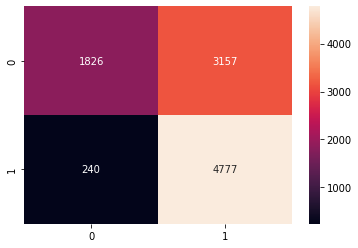

In [111]:
#confusion matrix for bag of words
cv_confusion_matrix=confusion_matrix(test_sentiment,cv_predict,labels=[1,0])
sns.heatmap(cv_confusion_matrix,annot=True,fmt = 'd')

In [98]:
text=["This was a very bad movie no one should ever watch it"]

In [99]:
text = cv.transform(text)

In [100]:
lb.inverse_transform(lr.predict(text))

array(['negative'], dtype='<U8')

In [103]:
# Training for Tf-Idf Vectors

lr=LogisticRegression(max_iter=512,random_state=14)

tv_model = lr.fit(tv_train_reviews,train_sentiment)

In [115]:
tv_predict = lr.predict(tv_test_reviews)

In [116]:
tv_report = classification_report(test_sentiment,tv_predict,target_names=['Positive','Negative'])

In [117]:
print(tv_report)

              precision    recall  f1-score   support

    Positive       0.76      0.75      0.75      5017
    Negative       0.75      0.76      0.76      4983

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



<AxesSubplot:>

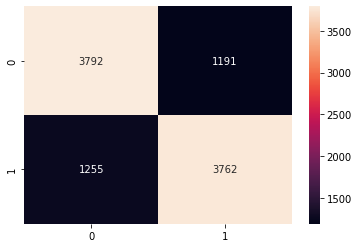

In [118]:
#confusion matrix for bag of words
cv_confusion_matrix=confusion_matrix(test_sentiment,tv_predict,labels=[1,0])
sns.heatmap(cv_confusion_matrix,annot=True,fmt = 'd')

## Using tensorflow and keras

In [3]:
df = pd.read_csv("IMDB Dataset cleaned.csv")

In [4]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewer have mention that af...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the film techniq...
2,I thought this was a wonderful way to spend ti...,positive,i thought this be a wonderful way to spend tim...
3,Basically there's a family where a little boy ...,negative,basically there be a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money be a ...


In [5]:
# Splitting into train test set
x_train,x_test,y_train, y_test = train_test_split(df["cleaned_review"],df["sentiment"],test_size=0.2,random_state=14)

In [6]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

40000
10000
40000
10000


In [7]:
# Creating a vocab size
vocab_size = 40000

# word embedding size
embedding_dim = 16

# Max length of the sequence
max_length = 250

# Out of vocab token
oov_tok = '<OOV>'

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [9]:
# Converting text into sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Padding the sequences
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating= 'post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post',truncating='post')

In [10]:
x_train

array([[   32,  1592,  5041, ...,     0,     0,     0],
       [  279,   212,     3, ...,     0,     0,     0],
       [   10,    19,  1806, ...,     0,     0,     0],
       ...,
       [21739, 15125,  4253, ...,     8,     3,    68],
       [  117,  4930,     5, ...,    12,   263,    59],
       [    2,    90,  1047, ...,     6,   467, 19590]])

In [11]:
y_train

42393    negative
33109    positive
834      negative
23499    positive
15111    negative
           ...   
23910    positive
44793    negative
22855    negative
9484     positive
13656    positive
Name: sentiment, Length: 40000, dtype: object

In [12]:
# Labelling the data
lb = LabelBinarizer()

y_train= lb.fit_transform(y_train).reshape(-1)
y_test = lb.transform(y_test).reshape(-1)

In [13]:
y_train = np_utils.to_categorical(y_train,2)
y_test = np_utils.to_categorical(y_test,2)

In [14]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(32,activation = 'relu'))
model.add(Dense(2,activation="softmax"))

In [15]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 640,610
Trainable params: 640,610
Non-trainable params: 0
_________________________________________________________________


In [17]:
num_epochs = 10
history = model.fit(x_train, y_train, epochs=num_epochs)

Epoch 1/10
1250/1250 [==============================] - 19s 6ms/step - loss: 0.5340 - accuracy: 0.7307
Epoch 2/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.2336 - accuracy: 0.9077
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1703 - accuracy: 0.9378
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1271 - accuracy: 0.9573
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0935 - accuracy: 0.9702
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0731 - accuracy: 0.9765
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0575 - accuracy: 0.9831
Epoch 8/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0429 - accuracy: 0.9864
Epoch 9/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0320 - accuracy: 0.9914
Epoch 10/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.02

In [18]:
accuracy = model.evaluate(x=x_test,y=y_test,batch_size=32)
print("Accuracy: ",accuracy[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.6725 - accuracy: 0.8596
Accuracy:  0.8596000075340271


In [19]:
np.argmax(model.predict(x_test),axis=1)

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

<AxesSubplot:>

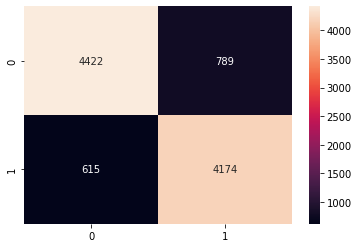

In [20]:
results = np.argmax(model.predict(x_test),axis =1)
y_test_matrix = np.argmax(y_test, axis = 1)

cv_confusion_matrix=confusion_matrix(results,y_test_matrix,labels=[1,0])
sns.heatmap(cv_confusion_matrix,annot=True,fmt = 'd')

#### Testing on random text

In [21]:
text = ["this was a really bad movie no one should ever watch it",
        "the best movie ever no movie can match this"]

In [22]:
text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text, maxlen=max_length, padding='post', truncating= 'post')
results = model.predict(text)

In [23]:
lb.inverse_transform(np.argmax(results,axis=1))

array(['negative', 'positive'], dtype='<U8')

In [24]:
# Saving the model
model.save('basic_keras_model.h5')

# Saving the Toneknizer
f =  open("tokenizer.pkl","wb")
pickle.dump(tokenizer,f)
f.close()

In [25]:
# Loading the saved model
model = load_model('basic_keras_model.h5')

# Loading the tokenizer
f = open("tokenizer.pkl","rb")
tokenizer = pickle.load(open("tokenizer.pkl","rb"))    

In [26]:
text = ["this was a really bad movie no one should ever watch it",
        "the best movie ever no movie can match this"]
text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text, maxlen=max_length, padding='post', truncating= 'post')
results = model.predict(text)
lb.inverse_transform(np.argmax(results,axis=1))

array(['negative', 'positive'], dtype='<U8')